# Regression

The following tasks will be completed withing this notebook:

1. Load from a local tsv file the mtcars data, building two sets of features with some fields one hot encoded, others standarized or kept as the are. 

2. Implement a function that takes a positive integer and a data set and retturns a the polynomial extended features. 

3. Implement the quadratic loss function with regularization and corresponding gradient functions

4. Implement stochastic gradient descent function that will return a parameter fit

5. Implement a cross validation procedure and search for a numner of lamda regularizations in $[0,1]$ for the best lambda and best feature set and polynomial order features

6. Come up with a direct algebaic solution and compare the RMSE of this one with the best obtained in 5. 


### Load data and make feature sets

In [228]:
import numpy as np
import pandas as pd
import csv
import itertools
from matplotlib import pyplot as plt

def load_data(path):
    '''
    takes path and returns a pnadas data frame object with the data from file under path
    '''
    data = []
    with open(path) as f:
        for row in csv.DictReader(f, delimiter='\t'):
            data.append(row)
    return pd.DataFrame(data)


def one_hot(x):
    '''
    @param x : pandas series object
    returns a data frame with the original series and the one hot encoded fields
    '''
    
    new_frame = pd.DataFrame(x)
    for val in x.unique():
        _name = str(int(val))
        new_frame[x.name + _name] = new_frame.apply(lambda col: 1 if col[x.name] == val else 0, axis=1)
    return new_frame.iloc[:,1:]
        
    
def standardize(x):
    '''
    @param x : string holding the name of the field to be standarized
    '''
    z = x.astype('float')
    result = np.array((z - np.mean(z))/np.std(z))

    return pd.DataFrame(result, columns=[x.name])


def make_features(feature_list):
    '''
    @param feature_list: a list of tuples, first entry is a pandas series and the next one is a string with 
    onehot or standardize. 
    '''
    new_features = []
    for f,ftype in feature_list:
        if ftype == 'onehot':
            new_features.append(one_hot(f))
        elif ftype == 'standardize':
            new_features.append(standardize(f))
        else:
            new_features.append(f)
        
    return pd.concat(new_features, axis=1)



auto_data = load_data('../code_and_data_for_hw05/auto-mpg-regression.tsv')

features1 = [
            (auto_data.cylinders, 'standardize'),
            (auto_data.displacement, 'standardize'),
            (auto_data.horsepower,'standardize'),
            (auto_data.weight, 'standardize'),
            (auto_data.acceleration, 'standardize'),
            (auto_data.origin, 'onehot'),
            (auto_data.mpg, 'standardize')
            ]

features2 = [
            (auto_data.cylinders, 'onehot'),
            (auto_data.displacement, 'standardize'),
            (auto_data.horsepower, 'standardize'),
            (auto_data.weight, 'standardize'),
            (auto_data.acceleration, 'standardize'),
            (auto_data.origin, 'onehot'),
            (auto_data.mpg, 'standardize')
            ]


auto_data_1 = make_features(features1)
auto_data_2 = make_features(features2)

# Keep this for future reference:
mean_mpg, sigma_mpg = auto_data['mpg'].astype('float').mean(), auto_data['mpg'].astype('float').std() 

### Make polynomial features

In [229]:
def make_polynomial_features(data, k):
    '''
    @param data: takes and array or data frame with features as columns
    @param k: int greater than 1
    returns an numpy array with polynomialy transformed features up to poly order k
    '''
    assert type(k)==int and k>=1
    
    raw_features = np.array(data)
    n,d = raw_features.shape
    if k == 1:
        return raw_features
    else:
        new_features = []
        # choose all k tuples from feature columns
        for i in range(1, k+1, 1):
            for t in itertools.combinations_with_replacement(range(d), i):
                tmp = np.ones((n,1))
                for j in range(len(t)): 
                    tmp = tmp*raw_features[:, [t[j]]]

                new_features.append(tmp)

    return np.hstack(new_features)


### Quadratic loss function and its gradient

In [230]:



def quadratic_loss(data, labels, theta, lam):
    '''
    return the quadratic loss with lambda regularization
    '''
    data = np.array(data)
    labels = np.array(labels)
    theta = np.array(theta)
    
    n,d = data.shape
    new_data = np.hstack((data, np.ones((n,1))))
    
    return (1/n) * np.linalg.norm((np.matmul(new_data, theta) - labels))**2 + lam * np.linalg.norm(theta[:,:-1])**2 


def quadratic_loss_grad(data, labels, theta, lam):
    '''
    return the quadratic loss with lambda regularization gradient
    '''
    data = np.array(data)
    labels = np.array(labels)
    theta = np.array(theta)
    
    n,d = data.shape
    new_data = np.hstack((data, np.ones((n,1))))

    
    d_th = (1/n) * np.matmul(2*(np.matmul(new_data, theta) - labels).T, data).T + 2 * lam * theta[:-1,:]
    d_th0 = (1/n) * np.matmul(2*(np.matmul(new_data, theta) - labels).T, np.ones((n,1)))

    return np.vstack((d_th, d_th0))

### Stochastic gradient descent

In [231]:
def sgd(loss, loss_grad, w0, data, labels, lam, step_size_fn, max_iter=1000, stochastic = True):
    '''
    Performs stochastic (or normal if stochastic=False) gradient descent
    
    return the fitted set of weigths w0, a list of intermiadaty loss values in a list loss_list and 
    a list of intermediary weights ws
    '''
    counter = 0
    n,d = data.shape
    
    loss_list = [loss(data, labels, w0, lam)]
    ws = [w0]
    
    while counter <= max_iter:
        
        counter += 1
        if stochastic:
            j = np.random.choice(n)
            delta = loss_grad(data[[j],:], labels[[j],0], w0, lam)
        else:
            delta = loss_grad(data, labels, w0, lam)

                
        w1 = w0 - step_size_fn(counter) * delta
        w0 = w1
    
        ws.append(w0)
        if stochastic:
            loss_list.append(loss(data[[j],:], labels[[j],0], w0, lam))
        else:
            loss_list.append(loss(data, labels, w0, lam))
        
    
    return (w0, loss_list, ws)


def step_size_fn(i):
    return 0.01

Run the SGD for one set of features and with an arbitratry chosen lambda = 0.1 just to see how it goes

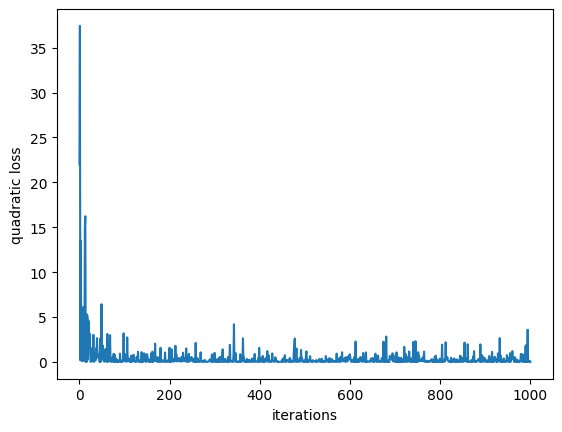

The loss went from 22.00338293967154 to 0.0019257274144147585 in 1000 iterations


In [232]:
data = np.array(auto_data_1.iloc[:,:-1])
theta = np.ones((data.shape[1]+1,1))
lam = 0.1
labels = np.array(auto_data_1.iloc[:,[-1]])

a,b,c = sgd(quadratic_loss, quadratic_loss_grad, theta, data, labels, lam, step_size_fn)

plt.plot(range(len(b)), b)
plt.xlabel('iterations')
plt.ylabel('quadratic loss')
plt.show()
print('The loss went from {} to {} in 1000 iterations'.format(b[0], b[-1]))

### Cross validation and searching for optimal hyper parameters

In [265]:
def RMSE(prediction, labels):
    '''
    @params: prediction, labels column vectors of same size (nx1)
    
    returns the RMS based on prediction and labels
    '''
    n = labels.shape[0]
    assert labels.shape == prediction.shape and labels.shape[1] == 1
    return ((1/n) * float(np.sum(np.matmul(prediction-labels, (prediction-labels).T))))**0.5
    

def eval_learner(
        loss, 
        loss_grad, 
        data_train, 
        labels_train, 
        data_test, 
        labels_test, 
        step_size_fn, 
        my_lam 
                ):
    
    '''
    returns the quadratic loss calculated on the test data set after fitting with SGD on the training data set
    '''
    n,d = data_train.shape

    theta = sgd(loss, loss_grad, np.zeros((d+1,1)), data_train, labels_train, my_lam, step_size_fn)[0]
    return quadratic_loss(data_test, labels_test, theta, my_lam)

    
def cross_validate(loss, loss_grad, data, labels, my_lam, step_size_fn,  k):
    '''
    perform k-fold cross validation and returns the averaged loss
    '''
    data_labels = np.hstack((data, labels))
    np.random.shuffle(data_labels) 
    
    results = 0
    
    data_split = np.array_split(data_labels, k, axis=0)
    
    for i in range(k):
        one_out = np.concatenate(data_split[0:i]+data_split[i+1:],axis=0)
        one = data_split[i]
    
        data_train,labels_train = one_out[:,:-1], one_out[:,[-1]]

        data_test,labels_test = one[:,:-1], one[:,[-1]]
        
        efficiency = eval_learner(
                            loss, 
                            loss_grad, 
                            data_train, 
                            labels_train, 
                            data_test, 
                            labels_test, 
                            step_size_fn,
                            my_lam
                                 )
        
        results += efficiency
    return(results/k)

#cross_validate(quadratic_loss, quadratic_loss_grad, data, labels, 0.1, step_size_fn, 2)

Now run cross validation for features1 and features2 and for regular features and polynomial of order 1, 2 & 3 features and for lambdas ranging from 0.0, 0.02, ...., 1

Finally we retrieve the optimal set of hyper paramters and fit theta.

In [234]:
best = {'cross_val': 99999, 'feature_set': -9, 'poly_order': -9, 'lam': -9}


for data_set in zip([auto_data_1, auto_data_2],range(1,3,1)):
    for k in [1,2,3]:
        for lam in [0.02*i for i in range(0,51,1)]:
            print('Working on feature set {}, poly order {},  lambda {}'.format(data_set[1], k, lam))
            data =  make_polynomial_features(np.array(data_set[0].iloc[:,:-1]), k)
            labels = np.array(data_set[0].iloc[:,[-1]])
            new  = cross_validate(quadratic_loss, quadratic_loss_grad, data, labels, lam, step_size_fn, 10)
            if new < best['cross_val']:
                best['cross_val'] = new
                best['poly_order'] = k
                best['lam'] = lam
                best['feature_set'] = data_set[1]

print(best)


Working on feature set 1, poly order 1,  lambda 0.0
Working on feature set 1, poly order 1,  lambda 0.02
Working on feature set 1, poly order 1,  lambda 0.04
Working on feature set 1, poly order 1,  lambda 0.06
Working on feature set 1, poly order 1,  lambda 0.08
Working on feature set 1, poly order 1,  lambda 0.1
Working on feature set 1, poly order 1,  lambda 0.12
Working on feature set 1, poly order 1,  lambda 0.14
Working on feature set 1, poly order 1,  lambda 0.16
Working on feature set 1, poly order 1,  lambda 0.18
Working on feature set 1, poly order 1,  lambda 0.2
Working on feature set 1, poly order 1,  lambda 0.22
Working on feature set 1, poly order 1,  lambda 0.24
Working on feature set 1, poly order 1,  lambda 0.26
Working on feature set 1, poly order 1,  lambda 0.28
Working on feature set 1, poly order 1,  lambda 0.3
Working on feature set 1, poly order 1,  lambda 0.32
Working on feature set 1, poly order 1,  lambda 0.34
Working on feature set 1, poly order 1,  lambda 0.

Working on feature set 2, poly order 1,  lambda 0.0
Working on feature set 2, poly order 1,  lambda 0.02
Working on feature set 2, poly order 1,  lambda 0.04
Working on feature set 2, poly order 1,  lambda 0.06
Working on feature set 2, poly order 1,  lambda 0.08
Working on feature set 2, poly order 1,  lambda 0.1
Working on feature set 2, poly order 1,  lambda 0.12
Working on feature set 2, poly order 1,  lambda 0.14
Working on feature set 2, poly order 1,  lambda 0.16
Working on feature set 2, poly order 1,  lambda 0.18
Working on feature set 2, poly order 1,  lambda 0.2
Working on feature set 2, poly order 1,  lambda 0.22
Working on feature set 2, poly order 1,  lambda 0.24
Working on feature set 2, poly order 1,  lambda 0.26
Working on feature set 2, poly order 1,  lambda 0.28
Working on feature set 2, poly order 1,  lambda 0.3
Working on feature set 2, poly order 1,  lambda 0.32
Working on feature set 2, poly order 1,  lambda 0.34
Working on feature set 2, poly order 1,  lambda 0.

{'cross_val': 0.2625486549616546, 'feature_set': 2, 'poly_order': 1, 'lam': 0.02}


### Comapare the SGD results with the direct solution through inverting matirces

First let's calculate the RMS for the best set of hyper parameters:

In [338]:
if best['feature_set']==1:
    data_set = auto_data_1
else:
    data_set = auto_data_2
    
    
data = make_polynomial_features(np.array(data_set.iloc[:,:-1]),best['poly_order'])
labels = np.array(data_set.iloc[:,[-1]])
lam = best['lam']
n,d = data.shape

theta_fit = sgd(quadratic_loss, quadratic_loss_grad, np.zeros((d+1,1)), data, labels, lam, step_size_fn)[0]

prediction_fit = np.matmul(np.hstack((data, np.ones((n,1)))),theta_fit)

print('For the best hyper parameters SGD gives a RMSE of {:.3f} and a quadratic loss of {:.3f}'\
      .format(RMSE(prediction_fit, labels), quadratic_loss(data, labels, theta_fit, lam)))




For the best hyper parameters SGD gives a RMSE of 1.776 and a quadratic loss of 0.277


Now lets do the direct algebraic solution

In [339]:
new_data = np.hstack((data, np.ones((n,1))))
theta_direct = np.matmul(np.matmul(np.linalg.inv(np.matmul(new_data.T, new_data) +\
                                                 n * lam * np.identity(d+1)), new_data.T), labels)


prediction_direct = np.matmul(np.hstack((data, np.ones((n,1)))),theta_direct)


print('For the best hyper parameters direct solution gives a RMSE of {:.3f} and a quadratic loss of {:.3f}'.\
      format(RMSE(prediction_direct, labels), quadratic_loss(data, labels, theta_direct, lam)))

For the best hyper parameters direct solution gives a RMSE of 0.016 and a quadratic loss of 0.250


### And just let's look at the proediction produced by SGD

In [340]:

prediction_fit_original = sigma_mpg * prediction_fit + mean_mpg
labels_original = np.array(auto_data.mpg.astype('float')).reshape((n,1))

prediction_direct_original = sigma_mpg * np.matmul(np.hstack((data, np.ones((n,1)))),theta_direct) + mean_mpg

results = pd.DataFrame(
            np.hstack((
                    labels_original,
                    prediction_fit_original, 
                    abs(prediction_fit_original-labels_original)/labels_original, 
                    prediction_direct_original, 
                    abs(prediction_direct_original-labels_original)/labels_original 
                    ))
            , columns=['mpg', 'prediction', 'error', 'prediction_direct', 'direct_error'])
                       

SSE = ((results['prediction'] - results['mpg'])**2).sum()
print ('RMSE of SGD is {:.3f}'.format((SSE/n)**0.5))

SSE_direct = ((results['prediction_direct'] - results['mpg'])**2).sum()
print ('RMSE of algebraic method is {:.3f}'.format((SSE_direct/n)**0.5))
results.head()

RMSE of SGD is 4.101
RMSE of algebraic method is 3.894


,mpg,prediction,error,prediction_direct,direct_error
0,18.0,18.283039,0.015724,19.107108,0.061506
1,15.0,15.135204,0.009014,16.049385,0.069959
2,18.0,16.921343,0.059925,18.003119,0.000173
3,16.0,17.146691,0.071668,17.938792,0.121174
4,17.0,17.551812,0.032460,18.664808,0.097930


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
